# Лабораторна робота 14,15

1. Опрацюйте код застосування автоенкодера на прикладі даних з електрокаріограми
2. Здійсніть навчання та дослідження якості автоенкодера на основі даних про шахрайство із кредитними картками

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
mpl.rcParams['figure.figsize'] = (10, 5)
mpl.rcParams['axes.grid'] = False

https://www.analyticsvidhya.com/blog/2022/01/complete-guide-to-anomaly-detection-with-autoencoders-using-tensorflow/

Завантаження бібліотек

Ми імпортуємо такі важливі бібліотеки, як pandas і numpy, щоб грати з даними (попередня обробка даних і типові математичні операції), matplotlib для візуалізації даних. Ми використовуємо Keras API, створений на основі TensorFlow для створення моделей.


In [2]:
#!cat "/ECG5000_TRAIN.txt" "/ECG5000_TEST.txt" > ecg_final.txt
df_TRAIN = pd.read_csv("ECG5000_TRAIN.txt", sep='  ', header=None)
df_TEST = pd.read_csv("ECG5000_TEST.txt", sep='  ', header=None)
df_TEST.shape

C:\Users\admin\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


(4500, 141)

In [3]:
df=pd.concat([df_TRAIN,df_TEST])
df.shape

(5000, 141)

In [4]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,1.0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,...,0.160348,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137
1,1.0,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,...,0.560327,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250
2,1.0,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,...,1.284825,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797
3,1.0,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,...,0.491173,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564
4,1.0,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,...,0.966606,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456


Основна попередня обробка
Pandas дає ім’я за замовчуванням як числове для назви стовпця, тому ми не можемо виконати будь-яку обробку, оскільки pandas не дозволяє нарізати та розрізати кубики, якщо ми маємо лише цифри в назві стовпця. Таким чином, ми додаємо будь-який префікс до назви стовпця, щоб виконати розділення стовпців.

In [5]:
df = df.add_prefix('c')
df['c0'].value_counts()

1.0    2919
2.0    1767
4.0     194
3.0      96
5.0      24
Name: c0, dtype: int64

Припустимо, ми бачимо кількість записів у кожній категорії за допомогою функції підрахунку значень. У цьому випадку ми бачимо, що 1 має більше спостережень, тому ми візьмемо першу категорію до нормальних даних і об’єднаємо дані з другої категорії в п’яту як ненормальні.

#### Train-Test Splitting and Scaling the data

Перш ніж розділити дані на нормальні та ненормальні, ми розділили дані на тренувальні та тестові набори. Нейронні мережі дають хорошу продуктивність, коли дані масштабуються за загальною шкалою, тому ми нормалізуємо дані.

In [6]:
x_train, x_test, y_train, y_test = train_test_split(df.values, df.values[:,0:1], test_size=0.2, random_state=111)

scaler = MinMaxScaler()
data_scaled = scaler.fit(x_train)
train_data_scaled = data_scaled.transform(x_train)
test_data_scaled = data_scaled.transform(x_test)

Розділіть аномальні та нормальні дані

Тепер ми розділимо навчальні дані на звичайні дані та дані аномалій. Ми знаємо, як розділити ці два набори даних на основі шкали даних потоку цінностей, що означає першу категорію в звичайних даних і решта даних категорії в аномальних даних. І те саме стосується даних тестів.

In [7]:
normal_train_data = pd.DataFrame(train_data_scaled).add_prefix('c').query('c0 == 0').values[:,1:]
anomaly_train_data = pd.DataFrame(train_data_scaled).add_prefix('c').query('c0 > 0').values[:, 1:]
normal_test_data = pd.DataFrame(test_data_scaled).add_prefix('c').query('c0 == 0').values[:,1:]
anomaly_test_data = pd.DataFrame(test_data_scaled).add_prefix('c').query('c0 > 0').values[:, 1:]

Тепер навчальний набір даних має власний фрейм даних норми та аномалії. Це розподіл 80-20. Набір даних не дуже дисбалансований, щоб нам потрібно було щось робити, але в будь-якому випадку, як і для Autoencoder, ми будемо навчатися лише зі звичайним набором даних. Набір даних про аномалії використовуватиметься лише для перевірки та пошуку висновків.

Візуалізація даних

Візуалізація даних життєво важлива для розуміння зв’язку між двома чи більше змінними. Щоб ми могли побачити, чим відрізняються дані, давайте спочатку побудуємо графік звичайних даних для трьох перших характеристик.

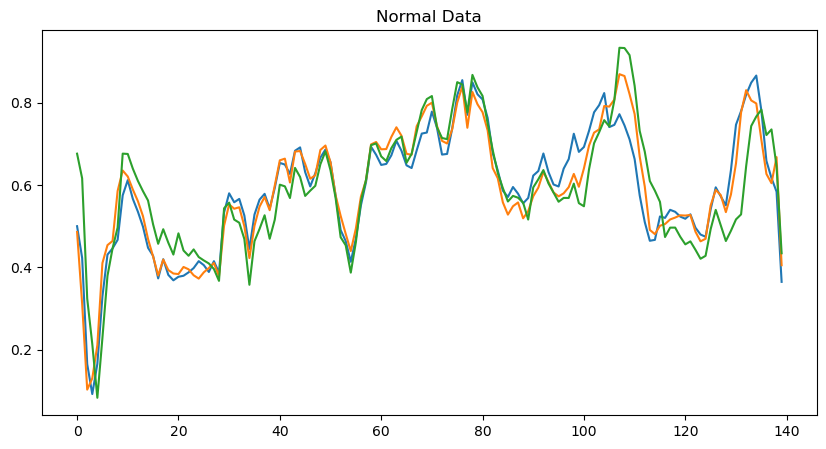

In [8]:
plt.plot(normal_train_data[0])
plt.plot(normal_train_data[1])
plt.plot(normal_train_data[2])
plt.title("Normal Data")
plt.show()

Перші три стовпчики намічаємо. На початковому рівні вона знижена, тому що звідти починається вимірювання ЕКГ, а потім рухається в звичайному режимі. 

Тепер побудуємо дані аномалії протилежно.

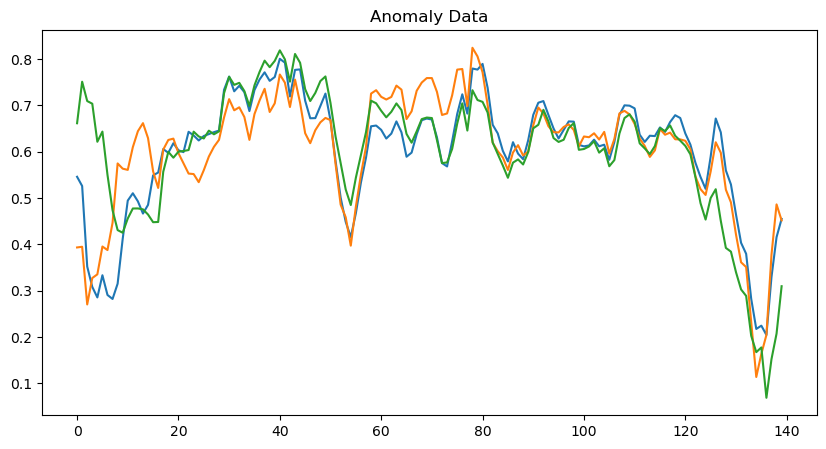

In [9]:
plt.plot(anomaly_train_data[0])
plt.plot(anomaly_train_data[1])
plt.plot(anomaly_train_data[2])
plt.title("Anomaly Data")
plt.show()

Спостерігаючи за наведеними вище графіками, можна легко зрозуміти різницю між нормальними та аномальними даними. Якщо ви пам’ятаєте про термін «помилка реконструкції», який ми обговорювали вище, ми будемо використовувати його для ідентифікації та диференціації аномальних і нормальних даних.

Моделювання

Щоб створити модель автокодувальника, є два способи. Один із них – використовувати послідовне моделювання, надане Keras API поверх TensorFlow. Спочатку ми додаємо рівень кодування, шари декодування та один проміжний рівень. Він перетворює дані з вищого виміру в нижчий вимір(). А потім, щоб відновити дані, він використовує модуль підвищення дискретизації. Наведений нижче фрагмент коду визначає цю архітектуру.

In [10]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(64, activation="relu"))
model.add(tf.keras.layers.Dense(32, activation="relu"))
model.add(tf.keras.layers.Dense(16, activation="relu"))
model.add(tf.keras.layers.Dense(8, activation="relu"))
model.add(tf.keras.layers.Dense(16, activation="relu"))
model.add(tf.keras.layers.Dense(32, activation="relu"))
model.add(tf.keras.layers.Dense(64, activation="relu"))
model.add(tf.keras.layers.Dense(140, activation="sigmoid"))

Різниця між введенням і виходом полягає в помилці реконструкції, яка буде дуже високою порівняно зі звичайними даними, яка використовується для розрізнення нормальних даних від аномальних.

Інший спосіб, який ми будемо використовувати subclassing або Model subclassing. Чому ми використовуємо його, тому що він говорить нам про те, щоб легко використовувати кодер і декодер окремо. Припустімо, якщо нам потрібна ця модель лише для стиснення даних, тоді я можу використовувати лише кодер. Таким чином, це дозволяє використовувати модель різними способами. Нижче наведено фрагмент коду та його пояснення.

In [11]:
class AutoEncoder(Model):
  def __init__(self):
    super(AutoEncoder, self).__init__()
    self.encoder = tf.keras.Sequential([
                  tf.keras.layers.Dense(64, activation="relu"),
                  tf.keras.layers.Dense(32, activation="relu"),
                  tf.keras.layers.Dense(16, activation="relu"),
                  tf.keras.layers.Dense(8, activation="relu")
              ])
    self.decoder = tf.keras.Sequential([
                  tf.keras.layers.Dense(16, activation="relu"),
                  tf.keras.layers.Dense(32, activation="relu"),
                  tf.keras.layers.Dense(64, activation="relu"),
                  tf.keras.layers.Dense(140, activation="sigmoid")
              ])
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

Пояснення ~ Вище ми створюємо клас і створюємо конструктор, а потім створюємо кодувальник таким же чином, зменшуючи порядок шарів, і 8 одиниць є шарами вузьких місць. Потім у нас є декодер, який виконує підвищення дискретизації даних, які зменшуються кодером, і, нарешті, вихід становить 140 одиниць. залежно від постановки задачі кількість одиниць змінюється. Остаточна функція активації — сигмоподібна. Функція виклику викликає кодер і передає вхідні дані, а закодовані дані передаються в декодер. Отже, цей Autoencoder є класом, і коли я запускаю цей клас, він повертає остаточний об’єкт моделі, який містить кодер, рівень вузького місця та декодер.

Скомпілюйте та навчіть модель

Ми додаємо феномен ранньої зупинки, який припиняє навчання, якщо втрати підтвердження не зменшуються після двох епох. Потім ми компілюємо модель за допомогою оптимізатора Adam. ми використовуємо MAE (середню абсолютну похибку) як функцію втрат. Тепер ми передаємо дані поїзда в модель (ми передаємо їх двічі, оскільки це обов’язкове поле, тому передаємо фіктивні значення Y). Ми додаємо 50 епох, але через ранню зупинку вона не запускатиме занадто багато епох. Якщо ви використовуєте дані часових рядів, то порядок важливий, тому для перемішування потрібно встановити значення False.

In [12]:
model = AutoEncoder()
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, mode="min")
model.compile(optimizer='adam', loss="mae")
history = model.fit(normal_train_data, normal_train_data, epochs=50, batch_size=120,
                    validation_data=(train_data_scaled[:,1:], train_data_scaled[:, 1:]),
                    shuffle=True,
                    callbacks=[early_stopping]
                    )

Epoch 1/50
20/20 [==============================] - 2s 24ms/step - loss: 0.1273 - val_loss: 0.1123
Epoch 2/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0813 - val_loss: 0.0838
Epoch 3/50
20/20 [==============================] - 0s 10ms/step - loss: 0.0539 - val_loss: 0.0781
Epoch 4/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0488 - val_loss: 0.0753
Epoch 5/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0479 - val_loss: 0.0750
Epoch 6/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0476 - val_loss: 0.0745
Epoch 7/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0474 - val_loss: 0.0737
Epoch 8/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0472 - val_loss: 0.0731
Epoch 9/50
20/20 [==============================] - 0s 10ms/step - loss: 0.0469 - val_loss: 0.0721
Epoch 10/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0464 - val_loss: 0.0702
Epoch 11/50
20/2

Оцінка моделі

В автокодерах різниця між втратою під час навчання та втратою перевірки є високою. Це не означає, що модель не підходить. Причина в тому, що у функції перевірки я надаю як звичайні дані, так і нестандартні дані проти тренувальних даних як звичайні дані, тож ви побачите таку поведінку, і це цілком нормально, тому ми зупиняємось достроково. Я можу отримати кодер і декодер окремо.

In [13]:
encoder_out = model.encoder(normal_test_data).numpy() #8 одиничне представлення даних
decoder_out = model.decoder(encoder_out).numpy()

По-перше, ми побудуємо графік продуктивності на звичайних даних, які є даними першого класу.

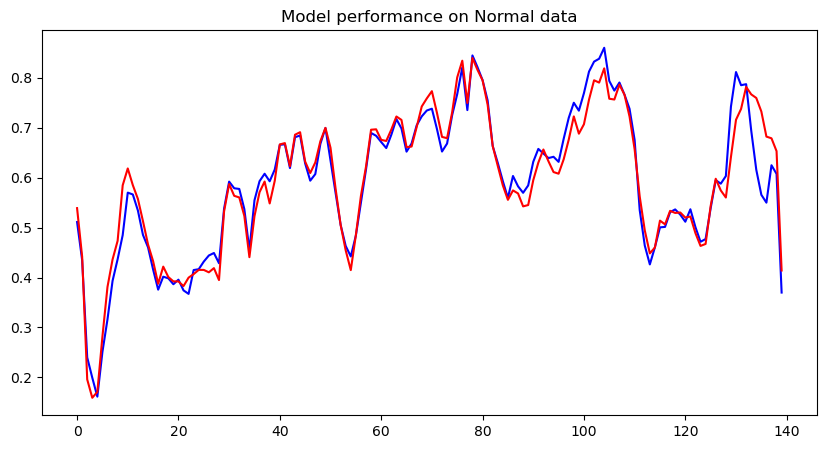

In [14]:
plt.plot(normal_test_data[0], 'b')
plt.plot(decoder_out[0], 'r')
plt.title("Model performance on Normal data")
plt.show()

Як обговорювалося, буде дуже невелика помилка реконструкції нормальних даних, яку ми можемо побачити на наведеному вище графіку. Різниця між червоною та синьою лініями дуже мала. 

Що якщо я пройду дані тесту на відхилення.

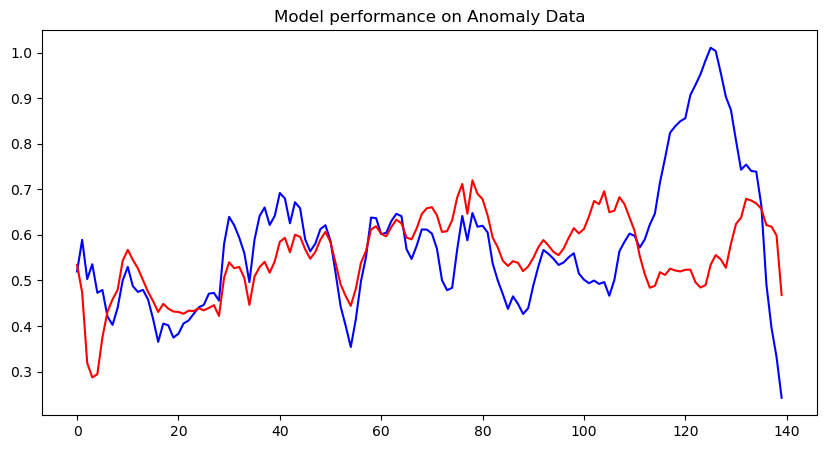

In [15]:
encoder_out_a = model.encoder(anomaly_test_data).numpy() #8 unit representation of data
decoder_out_a = model.decoder(encoder_out_a).numpy()
plt.plot(anomaly_test_data[0], 'b')
plt.plot(decoder_out_a[0], 'r')
plt.title("Model performance on Anomaly Data")
plt.show()

Угорі – це дані перевірки відхилень, а червоний – вихід декодера. якщо ви бачите, що помилка реконструкції тут досить висока. Тепер ми отримали дуже хорошу модель.

Розрахувати збиток

Тепер ми визначимо наші втрати як порогові втрати для нашої моделі, що дає нам вихідну помилку між входом і виходом. ми визначаємо функцію втрат Кераса над середньою абсолютною похибкою та будуємо її у вигляді гістограми.

18/18 [==============================] - 0s 3ms/step


(array([ 3., 10., 11., 35., 33., 34., 46., 29., 38., 42., 32., 29., 16.,
        12., 19., 31., 19., 13.,  7.,  5., 11.,  6., 10.,  9., 10.,  4.,
         4.,  4.,  7.,  8.,  4.,  2.,  1.,  1.,  3.,  1.,  0.,  3.,  0.,
         1.,  1.,  3.,  0.,  2.,  3.,  0.,  0.,  0.,  0.,  1.]),
 array([0.0118307 , 0.01361457, 0.01539844, 0.01718231, 0.01896619,
        0.02075006, 0.02253393, 0.0243178 , 0.02610168, 0.02788555,
        0.02966942, 0.03145329, 0.03323717, 0.03502104, 0.03680491,
        0.03858878, 0.04037265, 0.04215653, 0.0439404 , 0.04572427,
        0.04750814, 0.04929202, 0.05107589, 0.05285976, 0.05464363,
        0.05642751, 0.05821138, 0.05999525, 0.06177912, 0.063563  ,
        0.06534687, 0.06713074, 0.06891461, 0.07069848, 0.07248236,
        0.07426623, 0.0760501 , 0.07783397, 0.07961785, 0.08140172,
        0.08318559, 0.08496946, 0.08675334, 0.08853721, 0.09032108,
        0.09210495, 0.09388882, 0.0956727 , 0.09745657, 0.09924044,
        0.10102431]),
 <BarContainer

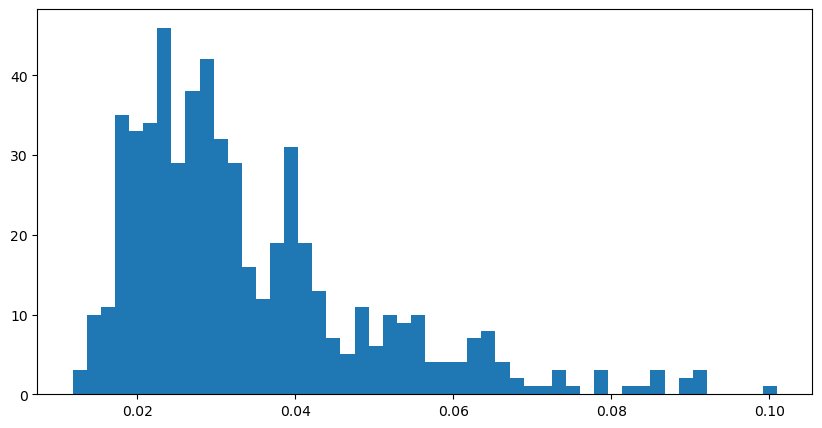

In [16]:
reconstruction = model.predict(normal_test_data)
train_loss = tf.keras.losses.mae(reconstruction, normal_test_data)
plt.hist(train_loss, bins=50)

Якщо ви бачите вісь Х, то більшість значень лежать нижче 0,05. є кілька аномалій, тому що ми не можемо мати 100% ідеальну модель. Ось як виглядає помилка між звичайними та реконструйованими даними. Тепер ми хочемо встановити порогове значення, за яким ми можемо визначити, що вище значення є аномаліями, а нижче — нормальними даними, тому ми беремо середнє значення втрати навчання та множимо його на два стандартні відхилення. Порогове значення має бути встановлено відповідно до бізнес-стандартів.

14/14 [==============================] - 0s 2ms/step


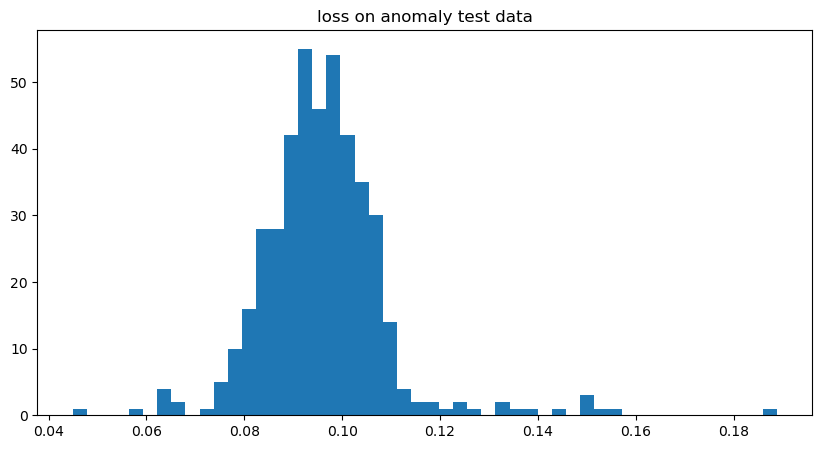

In [17]:
threshold = np.mean(train_loss) + 2*np.std(train_loss)
reconstruction_a = model.predict(anomaly_test_data)
train_loss_a = tf.keras.losses.mae(reconstruction_a, anomaly_test_data)
plt.hist(train_loss_a, bins=50)
plt.title("loss on anomaly test data")
plt.show()

Якщо ви бачили наведений вище графік, більшість даних були нижчими за 0,05, а якщо ми побудуємо гістограму на втраті тестових даних аномалії, то більшість даних перевищує 0,05. Слідкуйте за розмежуванням між нормальною втратою даних і аномальною втратою даних; отже, ми отримали дуже хорошу модель.

Побудуйте разом нормальну та аномальну втрату

Щоб отримати краще уявлення про те, як виглядають обидві втрати разом, давайте побудуємо обидві втрати разом із пороговим значенням. Тож ми передаємо нормальні втрати під час навчання та втрати аномалії в окремій гістограмі на одному графіку. ми малюємо вертикальну лінію на графіку, яка є порогом для кращої візуалізації.

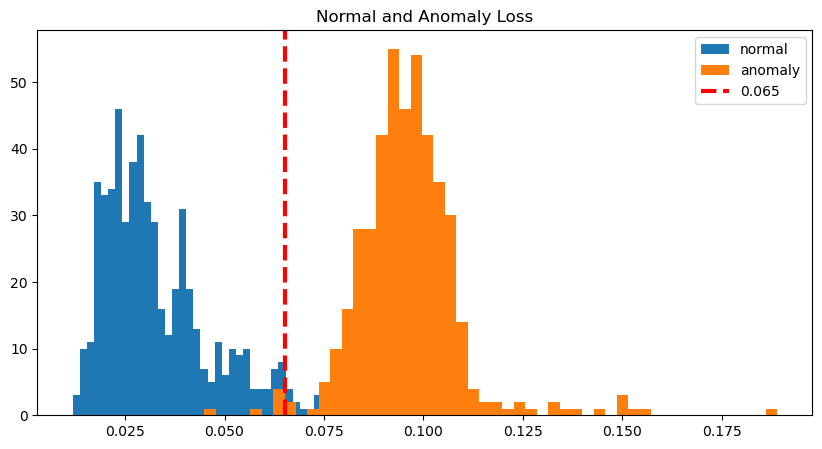

In [18]:
plt.hist(train_loss, bins=50, label='normal')
plt.hist(train_loss_a, bins=50, label='anomaly')
plt.axvline(threshold, color='r', linewidth=3, linestyle='dashed', label='{:0.3f}'.format(threshold))
plt.legend(loc='upper right')
plt.title("Normal and Anomaly Loss")
plt.show()

Тепер, якщо ви бачите середню втрату аномалії, тоді раніше вона становила 33 відсотки, але не 90 відсотків, що дуже далеко, але стандартне відхилення буде близьким. Тепер ми маємо дуже добре розуміння продуктивності моделі, тому давайте подивимося, скільки є помилкових спрацьовувань і помилкових негативів, щоб ми могли визначити середню продуктивність моделі.

Наскільки добре він прогнозує нормальний клас?

Дані аномалії – це дані, що перевищують порогове значення, тому ми використовуємо функцію TensorFlow max, щоб знайти значення, які є в даних аномалії.

In [19]:
preds = tf.math.less(train_loss, threshold)  #Повертає істинне значення (x < y) поелементно.
tf.math.count_nonzero(preds) #Обчислює кількість ненульових елементів за вимірами тензора.

<tf.Tensor: shape=(), dtype=int64, numpy=537>

Серед 563 загальних  нормальних записів він правильно прогнозує 537 значень, тому ми можемо сказати, що модель на 95 відсотків точна для прогнозування нормального класу.

Наскільки добре він працює з даними Anomaly?

Тепер ми використовуємо більшу функцію, щоб знайти кількість значень, які перевищують порогове значення, яке є аномаліями.

In [20]:
preds_a = tf.math.greater(train_loss_a, threshold)  #Повертає істинне значення (x > y) поелементно.
tf.math.count_nonzero(preds_a) #Обчислює кількість ненульових елементів за вимірами тензора.

<tf.Tensor: shape=(), dtype=int64, numpy=431>

З 437 загальних аномальних записів модель точно передбачила 431, що означає, що остаточна модель точна на 90-95 відсотків у передбаченні нових точок.

Кінцеві примітки
Це перша модель автокодувальника з нуля для виявлення аномалій, яка досить добре працює з новими невидимими даними. Ви можете використовувати іншу архітектуру, як-от LSTM, згортковий 1-d тощо, але це базова модель лише для того, щоб ви могли зрозуміти роботу та вимоги Autoencoder у сучасному світі даних і як йому вдається давати кращі результати, ніж інші моделі, такі як PCA, ізольований ліс.

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0289 - val_loss: 0.0163
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0139 - val_loss: 0.0100
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0093 - val_loss: 0.0081
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0075 - val_loss: 0.0065
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0060 - val_loss: 0.0053
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0048 - val_loss: 0.0046
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0043 - val_loss: 0.0043
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0038 - val_loss: 0.0038
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0032 - val_lo

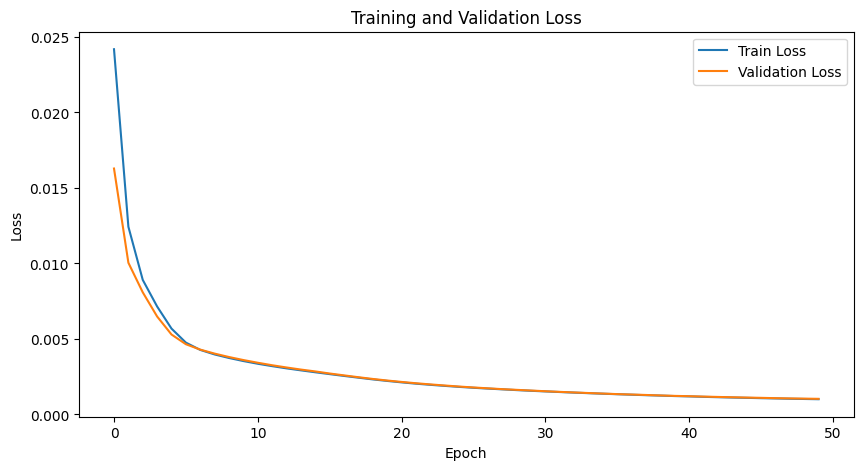

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


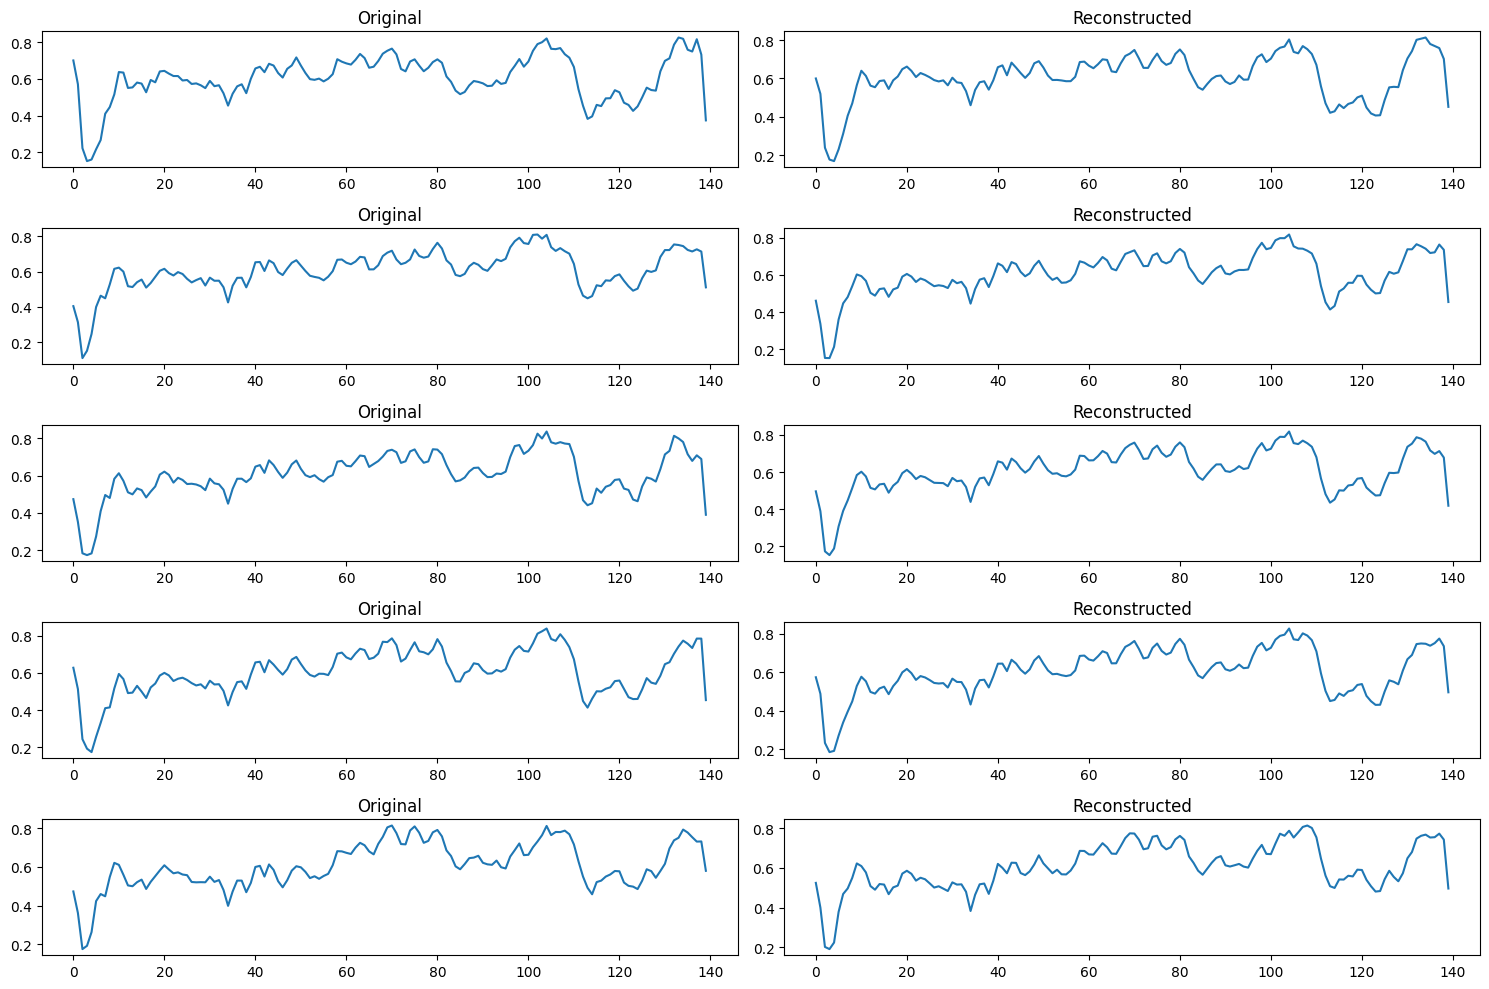

In [22]:
# Імпорт бібліотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Налаштування графіки
mpl.rcParams['figure.figsize'] = (10, 5)
mpl.rcParams['axes.grid'] = False

# Завантаження даних
df_TRAIN = pd.read_csv("ECG5000_TRAIN.txt", sep='  ', header=None, engine='python')
df_TEST = pd.read_csv("ECG5000_TEST.txt", sep='  ', header=None, engine='python')
df = pd.concat([df_TRAIN, df_TEST])

# Відокремлення міток та ознак
labels = df.iloc[:, 0].values
features = df.iloc[:, 1:].values

# Масштабування даних
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

# Розділення на тренувальний та тестовий набори
X_train, X_test, y_train, y_test = train_test_split(features_scaled, labels, test_size=0.2, random_state=42)

# Створення автоенкодера
input_dim = X_train.shape[1]
encoding_dim = 32

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation="relu")(input_layer)
decoded = Dense(input_dim, activation="sigmoid")(encoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Навчання автоенкодера
history = autoencoder.fit(
    X_train, X_train,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_data=(X_test, X_test)
)

# Побудова графіків втрат
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Реконструкція прикладів
decoded_samples = autoencoder.predict(X_test)

# Візуалізація справжніх та відновлених сигналів
n = 5
plt.figure(figsize=(15, 10))
for i in range(n):
    ax = plt.subplot(5, 2, 2*i+1)
    plt.plot(X_test[i])
    plt.title("Original")
    ax = plt.subplot(5, 2, 2*i+2)
    plt.plot(decoded_samples[i])
    plt.title("Reconstructed")
plt.tight_layout()
plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step


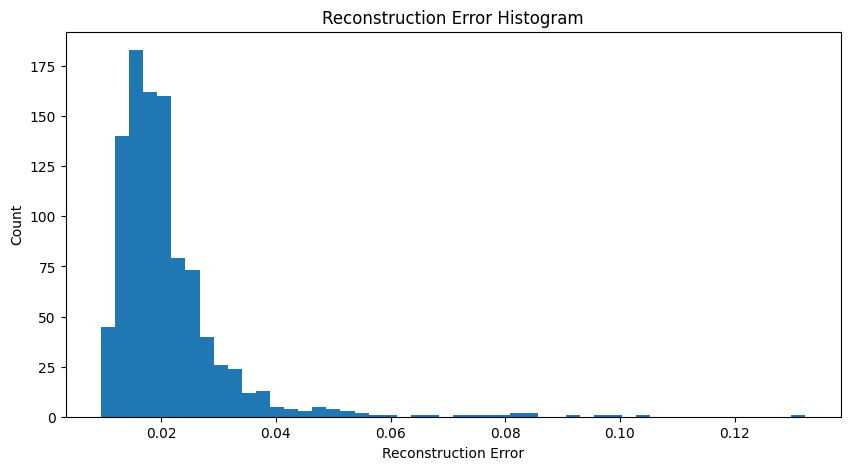

Threshold for anomaly detection: 0.0435

Confusion Matrix:
[[570  16]
 [396  18]]

Classification Report:
              precision    recall  f1-score   support

       False     0.5901    0.9727    0.7345       586
        True     0.5294    0.0435    0.0804       414

    accuracy                         0.5880      1000
   macro avg     0.5597    0.5081    0.4074      1000
weighted avg     0.5650    0.5880    0.4637      1000



In [23]:
# --- Новий код для виявлення аномалій ---

# Обчислення реконструктивної помилки для тестових даних
reconstructions = autoencoder.predict(X_test)
reconstruction_errors = np.mean(np.abs(reconstructions - X_test), axis=1)

# Побудова гістограми помилок реконструкції
plt.hist(reconstruction_errors, bins=50)
plt.title('Reconstruction Error Histogram')
plt.xlabel('Reconstruction Error')
plt.ylabel('Count')
plt.show()

# Встановлення порогу для виявлення аномалій
threshold = np.mean(reconstruction_errors) + 2*np.std(reconstruction_errors)
print(f"Threshold for anomaly detection: {threshold:.4f}")

# Прогнозування: якщо помилка більше за поріг - це аномалія
y_pred = reconstruction_errors > threshold

# Фактичні аномалії: мітки не рівні 1 (у цьому датасеті нормальні = 1, решта - аномалії)
# Тобто все що не 1 — аномалія
y_true = y_test != 1

# Оцінка якості виявлення
from sklearn.metrics import confusion_matrix, classification_report

print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))

print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4))


Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0251 - val_loss: 0.0126
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0112 - val_loss: 0.0090
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0085 - val_loss: 0.0075
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0068 - val_loss: 0.0058
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0053 - val_loss: 0.0048
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0044 - val_loss: 0.0043
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0041 - val_loss: 0.0039
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0037 - val_loss: 0.0036
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0028 - val_lo

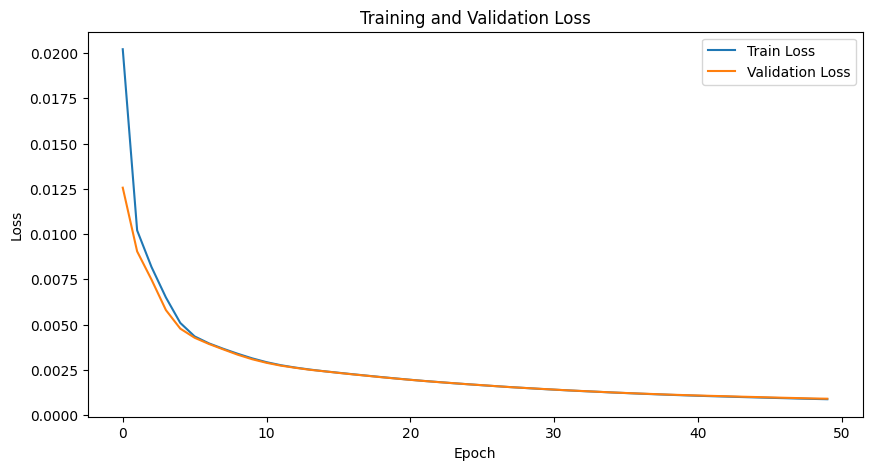

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


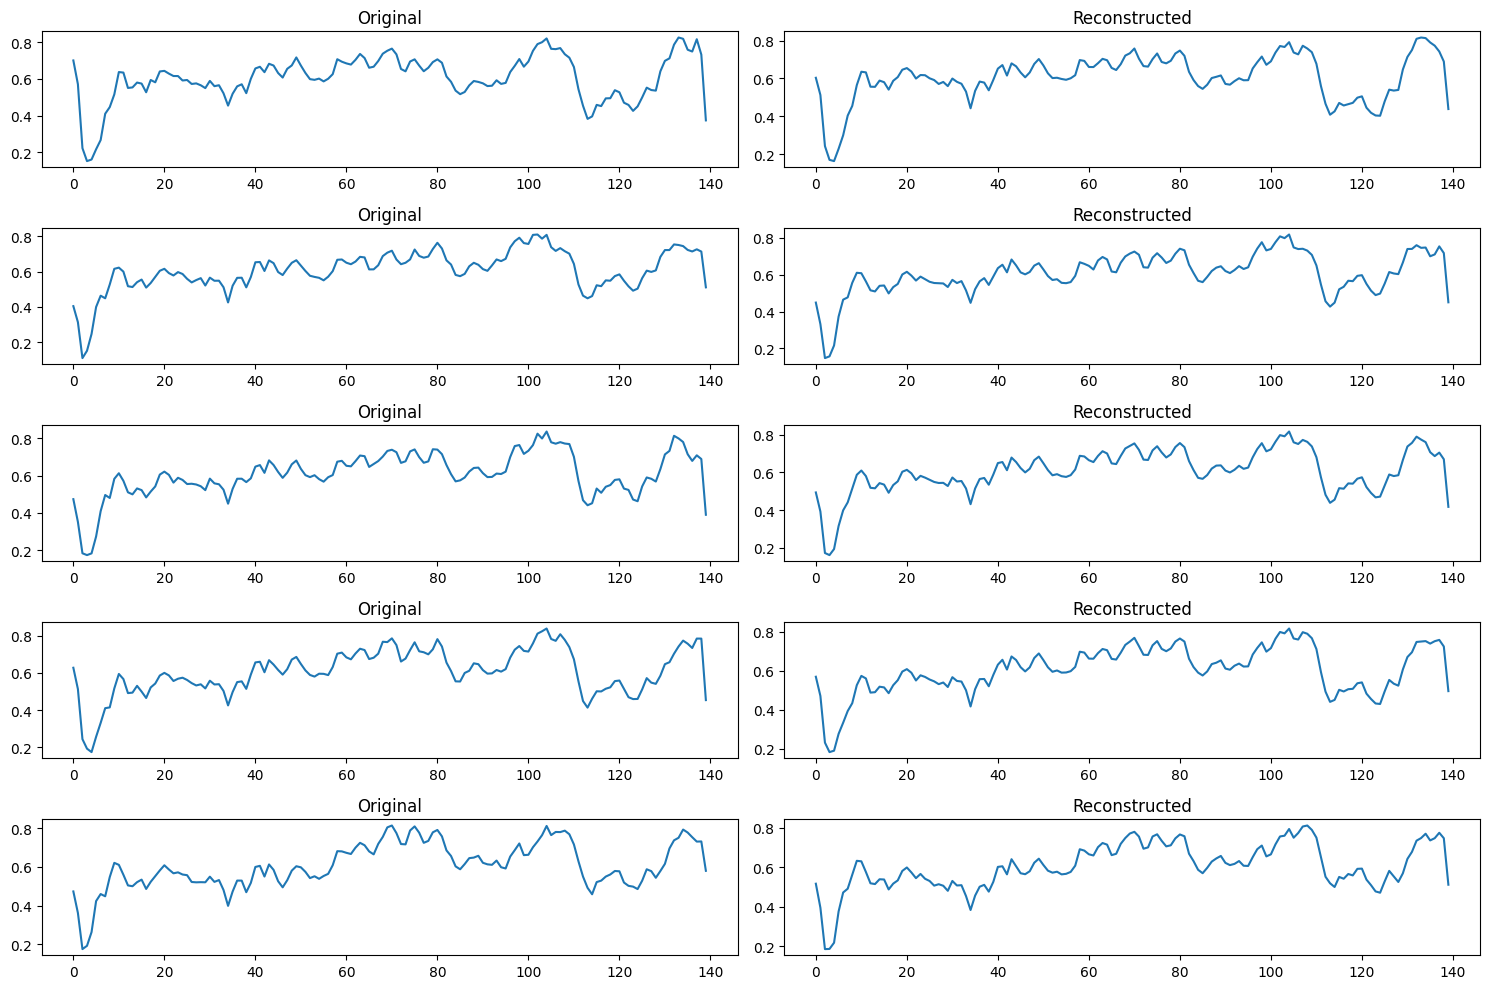

Threshold for anomaly detection: 0.004525620224015281
[[580   6]
 [401  13]]
              precision    recall  f1-score   support

           0       0.59      0.99      0.74       586
           1       0.68      0.03      0.06       414

    accuracy                           0.59      1000
   macro avg       0.64      0.51      0.40      1000
weighted avg       0.63      0.59      0.46      1000



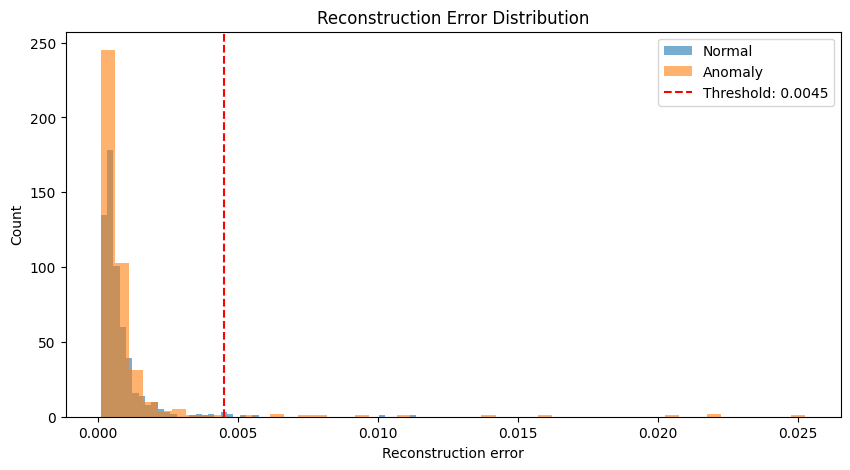

In [24]:
# Імпорт бібліотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Налаштування графіки
mpl.rcParams['figure.figsize'] = (10, 5)
mpl.rcParams['axes.grid'] = False

# Завантаження даних
df_TRAIN = pd.read_csv("ECG5000_TRAIN.txt", sep='  ', header=None, engine='python')
df_TEST = pd.read_csv("ECG5000_TEST.txt", sep='  ', header=None, engine='python')
df = pd.concat([df_TRAIN, df_TEST])

# Відокремлення міток та ознак
labels = df.iloc[:, 0].values
features = df.iloc[:, 1:].values

# Масштабування даних
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

# Розділення на тренувальний та тестовий набори
X_train, X_test, y_train, y_test = train_test_split(features_scaled, labels, test_size=0.2, random_state=42)

# Створення автоенкодера
input_dim = X_train.shape[1]
encoding_dim = 32

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation="relu")(input_layer)
decoded = Dense(input_dim, activation="sigmoid")(encoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Навчання автоенкодера
history = autoencoder.fit(
    X_train, X_train,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_data=(X_test, X_test)
)

# Побудова графіків втрат
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Реконструкція прикладів
decoded_samples = autoencoder.predict(X_test)

# Візуалізація справжніх та відновлених сигналів
n = 5
plt.figure(figsize=(15, 10))
for i in range(n):
    ax = plt.subplot(5, 2, 2*i+1)
    plt.plot(X_test[i])
    plt.title("Original")
    ax = plt.subplot(5, 2, 2*i+2)
    plt.plot(decoded_samples[i])
    plt.title("Reconstructed")
plt.tight_layout()
plt.show()

# === Доданий код для виявлення аномалій ===

# Розрахунок похибок реконструкції
reconstruction_errors = np.mean(np.square(X_test - decoded_samples), axis=1)

# Визначення порогу виявлення аномалій
threshold = np.mean(reconstruction_errors) + 2*np.std(reconstruction_errors)
print(f"Threshold for anomaly detection: {threshold}")

# Класифікація
predictions = (reconstruction_errors > threshold).astype(int)  # 1 - anomaly, 0 - normal
true_anomalies = (y_test != 1).astype(int)  # У наборі 1 - normal, інше - anomaly

# Оцінка якості
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(true_anomalies, predictions))
print(classification_report(true_anomalies, predictions))

# Гістограми розподілу
plt.hist(reconstruction_errors[true_anomalies==0], bins=50, alpha=0.6, label="Normal")
plt.hist(reconstruction_errors[true_anomalies==1], bins=50, alpha=0.6, label="Anomaly")
plt.axvline(threshold, color='r', linestyle='--', label=f"Threshold: {threshold:.4f}")
plt.legend()
plt.title("Reconstruction Error Distribution")
plt.xlabel("Reconstruction error")
plt.ylabel("Count")
plt.show()


Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1141 - val_loss: 0.0743
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0707 - val_loss: 0.0636
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0613 - val_loss: 0.0565
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0554 - val_loss: 0.0520
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0511 - val_loss: 0.0472
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0454 - val_loss: 0.0413
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0406 - val_loss: 0.0384
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0378 - val_loss: 0.0360
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0361 - val_loss: 0.0347
Epoch 10/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0336 - val_loss: 0.0326
Epoch 11/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0327 - val_loss: 0.0313
Epoch 12/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.

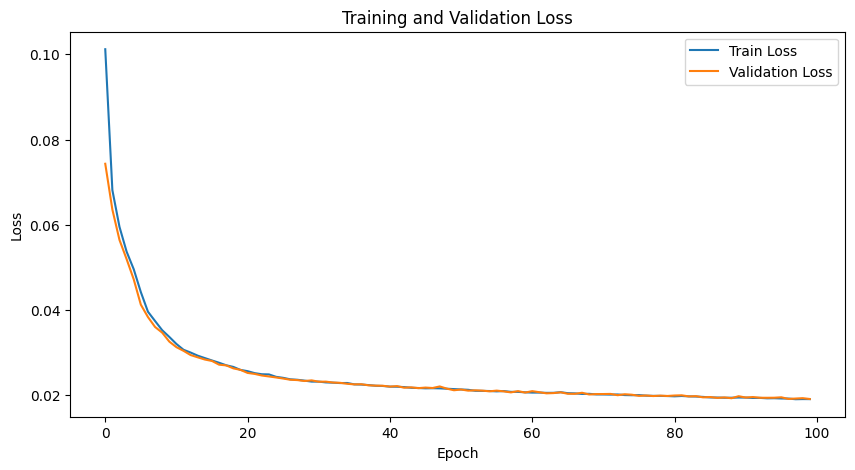

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step
Threshold for anomaly detection: 0.045628140831441066
[[ 571   13]
 [ 138 1943]]
              precision    recall  f1-score   support

           0       0.81      0.98      0.88       584
           1       0.99      0.93      0.96      2081

    accuracy                           0.94      2665
   macro avg       0.90      0.96      0.92      2665
weighted avg       0.95      0.94      0.95      2665



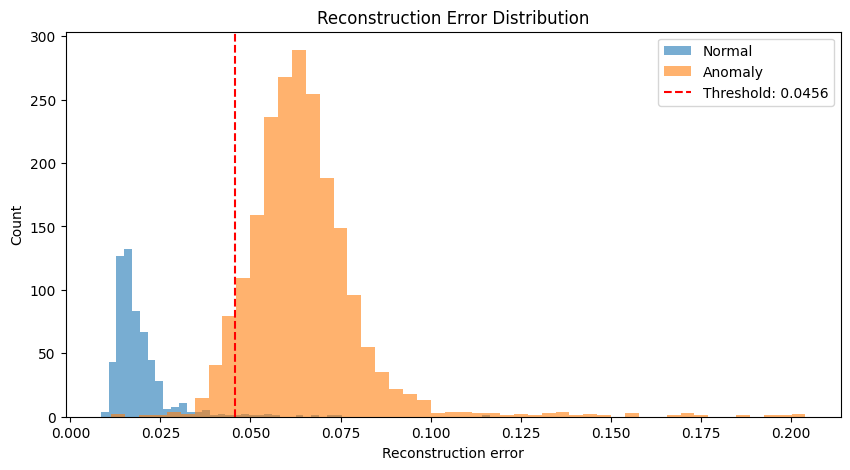